In [1]:
# Core imports
from mycore import ast2station_rotating, ast2station_rotating2

# Main imports
import heyoka as hy
import pykep as pk
import pygmo as pg
import pygmo_plugins_nonfree as ppnf

# Usual imports
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Jupyter setup
#%matplotlib notebook
#%load_ext autoreload
#%autoreload 2  # Autoreload all modules

# Defining the nominal case to be solved

In [2]:
# Orbital parameters defining the starting position in t0 and an inertial frame
ecc = 0.23
incl = 0.116
sma = 2.687 * pk.AU
W = 3.137
w = 4.453
E = 4.189 # 3.01
osculating = [sma, ecc, incl, W, w, E]

# Target orbit definition (it is assumed, in t0, the target is in r,0,0)
r_target = 1.3 * pk.AU
omega = np.sqrt(pk.MU_SUN / r_target**3)

In [3]:
# Starting state in the inertial frame
r,v = pk.par2ic(osculating, pk.MU_SUN)
#starting state in the rotating frame (in t0 its overlapped)
v = list(v)
r = list(r)

In [4]:
# We move it to the rotating frame
v[0] = v[0] + omega * r[1]
v[1] = v[1] - omega * r[0]

(-3.5, 3.5)

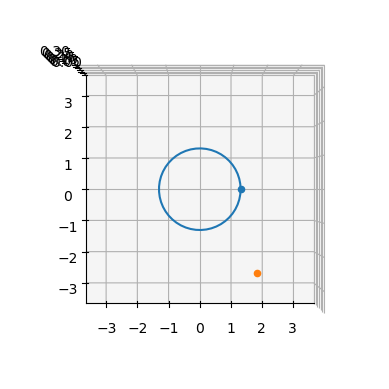

In [5]:
# Visualizing
udp = ast2station_rotating2(
    x0 = [r[0],r[1],r[2],v[0],v[1],v[2]],
    r_target = r_target
)
ax = udp.plot_initial_conditions()
ax.view_init(90, 270)
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)

# Solving the nominal case

In [6]:
# Algorithm
uda = ppnf.snopt7(screen_output = False, library = r"/usr/local/lib/libsnopt7_c.so", minor_version=2)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-12)
uda.set_numeric_option("Major iterations limit", 1000)
algo = pg.algorithm(uda)

In [7]:
# Problem
udp = ast2station_rotating2(
    x0 = [r[0],r[1],r[2],v[0],v[1],v[2]],
    r_target = r_target
)
prob = pg.problem(udp)
prob.c_tol = 1e-4

In [8]:
# Random initial guess
pop = pg.population(udp)
ic_l = np.random.uniform(-1,1,7)
ic_l[-1] = np.abs(ic_l[-1])
ic_l = np.append(ic_l, 30.)
pop.push_back(x = ic_l)


(-3.5, 3.5)

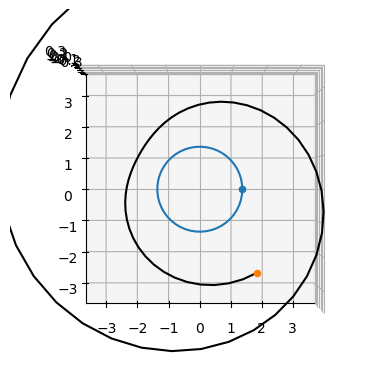

In [9]:
# Visualize the guess
ax = udp.plot(pop.champion_x, inertial=False)
ax.view_init(90, 270)
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)

In [10]:
import time
# Solve
while True:
    pop = pg.population(udp)
    ic_l = np.random.uniform(-1,1,7)
    ic_l[-1] = np.abs(ic_l[-1])
    ic_l = np.append(ic_l, 20 + np.random.rand()*20)
    pop.push_back(x = ic_l)
    tstart = time.time()
    pop = algo.evolve(pop)
    tend = time.time()

    err = np.linalg.norm(pop.champion_f[1:])
    print("Error: " , err)
    print("CPU time:", tend-tstart)
    if err < 1e-10: 
        break
x = pop.champion_x
l = x[:-1]
print("Time of flight:", x[-1])
print("Time of flight (years):", x[-1] * udp.TIME * pk.SEC2DAY / 365.25)

Error:  2.428652628339868e-14
CPU time: 0.3475475311279297
Time of flight: 19.56982429599004
Time of flight (years): 3.114693096961322


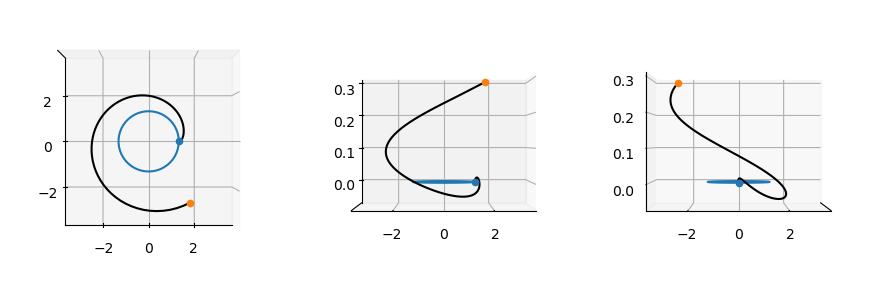

In [11]:
# Visualize
fig = plt.figure(figsize= (9,3))

ax = fig.add_subplot(1, 3, 1, projection='3d')
udp.plot(pop.champion_x, inertial=False, axes=ax)
ax.view_init(90, 270)
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)
ax.axis('on')
ax.set_zticks([])

ax = fig.add_subplot(1, 3, 2, projection='3d')
udp.plot(pop.champion_x, inertial=False, axes=ax)
ax.view_init(0, 270)
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)
ax.set_yticks([])

ax = fig.add_subplot(1, 3, 3, projection='3d')
udp.plot(pop.champion_x, inertial=False, axes=ax)
ax.view_init(0, 0)
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)
ax.set_xticks([])

plt.tight_layout()

In [ ]:
plt.savefig("figures/nominal.png", dpi=600)

In [12]:
x0 = [r[0],r[1],r[2],v[0],v[1],v[2]]
r_target = r_target
with open("data/nominal_E_4_189.pk", "wb") as file:
    pkl.dump([x0, r_target, pop.champion_x], file)